# DTW Algorithm, Retrieval and Evaluation (Recall, precision, AP)

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from tslearn.metrics import dtw
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

## Load Data

### Feature vectors

In [33]:
from FeatureVectors import load_images
from FeatureVectors import getFeaturesMatrix
results, numbers = load_images()
allfeatures = getFeaturesMatrix(numbers, results.keys())

pkl exists
[270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 300, 301, 302, 303, 304]
Starting masking and binarisation
Loading binarised data from pkl\270_words.pkl
Page 270 done
Loading binarised data from pkl\271_words.pkl
Page 271 done
Loading binarised data from pkl\272_words.pkl
Page 272 done
Loading binarised data from pkl\273_words.pkl
Page 273 done
Loading binarised data from pkl\274_words.pkl
Page 274 done
Loading binarised data from pkl\275_words.pkl
Page 275 done
Loading binarised data from pkl\276_words.pkl
Page 276 done
Loading binarised data from pkl\277_words.pkl
Page 277 done
Loading binarised data from pkl\278_words.pkl
Page 278 done
Loading binarised data from pkl\279_words.pkl
Page 279 done
Loading binarised data from pkl\300_words.pkl
Page 300 done
Loading binarised data from pkl\301_words.pkl
Page 301 done
Loading binarised data from pkl\302_words.pkl
Page 302 done
Loading binarised data from pkl\303_words.pkl
Page 303 done
Loading binarised data from pkl\304_wor

Dictionary fusion: 100%|████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15001.09it/s]


Dictionary fusionned


Normalisation: 100%|█████████████████████████████████████████████████████████████| 3726/3726 [00:02<00:00, 1377.16it/s]


Preprocessing done
Loading feature dictionary from pkl\270_features.pkl
Page 270 done
Loading feature dictionary from pkl\271_features.pkl
Page 271 done
Loading feature dictionary from pkl\272_features.pkl
Page 272 done
Loading feature dictionary from pkl\273_features.pkl
Page 273 done
Loading feature dictionary from pkl\274_features.pkl
Page 274 done
Loading feature dictionary from pkl\275_features.pkl
Page 275 done
Loading feature dictionary from pkl\276_features.pkl
Page 276 done
Loading feature dictionary from pkl\277_features.pkl
Page 277 done
Loading feature dictionary from pkl\278_features.pkl
Page 278 done
Loading feature dictionary from pkl\279_features.pkl
Page 279 done
Loading feature dictionary from pkl\300_features.pkl
Page 300 done
Loading feature dictionary from pkl\301_features.pkl
Page 301 done
Loading feature dictionary from pkl\302_features.pkl
Page 302 done
Loading feature dictionary from pkl\303_features.pkl
Page 303 done
Loading feature dictionary from pkl\304_fea

In [34]:
# replace every none value by 0 for DTW calculation
for key in allfeatures.keys():
    length = len(allfeatures[key])
    for line in range(0,length):
        allfeatures[key][line]=[0.0 if v is None else v for v in allfeatures[key][line]]

In [35]:
allfeatures['270-01-01']

[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
 [50, 43, 2, 0.04938271604938271, 1.0, 0.0],
 [51, 42, 2, 0.06172839506172839, 1.0, 0.7777777777777778],
 [76, 40, 4, 0.09259259259259259, 0.40540540540540543, 0.25],
 [77, 39, 4, 0.11728395061728394, 0.48717948717948717, 0.9473684210526315],
 [77, 38, 4, 0.12345679012345678, 0.5, 0.9743589743589743],
 [77, 37, 4, 0.13580246913580246, 0.5365853658536586, 0.975],
 [77, 36, 4, 0.14814814814814814, 0.5714285714285714, 0.975609756097561],
 [76, 35, 4, 0.15432098765432098, 0.5952380952380952, 1.0],
 [76, 34, 4, 0.16666666666666666, 0.627906976744186, 0.9761904761904762],
 [76, 33, 4, 0.17901234567901234, 0.6590909090909091, 0.9767441860465116],
 [75, 32, 4, 0.17901234567901234, 0.6590909090909091, 1.0],
 [74, 32, 4, 0.1790123456790

### Train and validation set

In [36]:
# task folder locations
dataset = os.path.join('..', 'dataset')
task_fold = os.path.join(dataset, 'task')
# training list
train_f = open(os.path.join(task_fold, 'train.txt'), "r")
train_list = []
for l in train_f:
    train_list.append(l[:3])
# validation list
val_f = open(os.path.join(task_fold, 'valid.txt'), "r")
val_list = []
for l in val_f:
    val_list.append(l[:3])
# create training and validation dataset
train_dataset = {}
val_dataset = {}
for key in allfeatures.keys():
    if key[:3] in train_list:
        train_dataset[key] = allfeatures[key]
    elif key[:3] in val_list:
        val_dataset[key] = allfeatures[key]
    else:
        print(f'{key} is not included in training or validation dataset')

print('train_dataset and val_dataset created')

train_dataset and val_dataset created


### Transcription

In [24]:
# ground-truth folder location
groundtruth = os.path.join(dataset, 'ground-truth')
transcription_f = open(os.path.join(groundtruth, 'transcription.txt'), "r")
transcription = {}
for l in transcription_f:
    key_word = l.split()
    transcription[key_word[0]] = key_word[1]
print('Transcriptions loaded.')

Transcriptions loaded.


In [7]:
transcription['270-03-01']

'o-n-l-y'

In [25]:
#load the words that appear both in training and validation set
keywords_f = open(os.path.join(task_fold, 'keywords.txt'), "r")
keywords_list = []
for l in keywords_f:
    keywords_list.append(l[:len(l)-1])
print('Keywords loaded.')

Keywords loaded.


## DTW Algorithm

References :
* [Install tslearn](https://tslearn.readthedocs.io/en/latest/installation.html)
* [tslearn.metrics](https://tslearn.readthedocs.io/en/stable/gen_modules/metrics/tslearn.metrics.dtw.html#tslearn.metrics.dtw)


In [9]:
cost_results = {}
#check if we already calculated the results, if not do it
file = os.path.join('cost_results', 'results.pkl')
if not os.path.isfile(file):
    #warning: the following two for loops takes a lot of time to compute
    for val_vector in val_dataset:
        # !!! uncomment the following line and add increment such that it works if you want to compute only meaningful results !!!
        #if transcription[val_vector] in keywords_list:
        cost_results[val_vector] = {}
        for train_vector in train_dataset:
            cost = dtw(val_dataset[val_vector],
                       train_dataset[train_vector],
                       global_constraint="sakoe_chiba",
                       sakoe_chiba_radius=3)
            cost_results[val_vector][train_vector] = cost
    #save the cost results
    with open('cost_results/results.pkl', 'wb') as f:
        pickle.dump(cost_results, f, pickle.HIGHEST_PROTOCOL)
    print('DTW results saved')
else:
    #if the results already exists, load them
    with open(file, 'rb') as f:
        cost_results = pickle.load(f)
    print('DTW results loaded')
    

DTW results loaded


In [77]:
cost_results['300-02-03']

{'271-02-05': 266.9592258382709,
 '275-25-05': 364.30889868342035,
 '279-11-06': 372.14705278093135,
 '272-13-05': 382.38217130983253,
 '273-35-06': 391.4442049598787,
 '273-20-05': 392.2561780215591,
 '275-05-10': 393.61980501368583,
 '276-12-02': 401.6898781983024,
 '270-30-08': 402.25818415636843,
 '278-25-02': 402.50738609727955,
 '273-15-08': 421.96770453745216,
 '271-27-04': 422.3100566709575,
 '279-06-09': 426.35357387193886,
 '274-32-01': 430.34810589672674,
 '279-04-03': 432.29798180746906,
 '272-24-04': 438.8674334516563,
 '273-30-06': 439.837816895417,
 '271-35-07': 440.0293554125315,
 '271-09-04': 444.1559725243877,
 '271-23-02': 451.920698340774,
 '271-05-04': 452.9562385927242,
 '272-29-03': 454.09410380802007,
 '274-22-03': 454.84173032257314,
 '274-20-02': 455.30021842045875,
 '272-30-04': 458.1018911555517,
 '274-25-07': 462.22598865071114,
 '273-01-02': 464.1731295242854,
 '272-34-02': 464.26909646482284,
 '273-03-05': 471.60831702174823,
 '278-01-03': 472.31225312372

## Evaluation

### The idea :
Define thresholds k for considering a certain cost as a limit
to choose results below the limit as positive (similar to the test word) 
and after the limit as negative (not similar to the test word)

Then for each k:

a)  check from top to k if it is a true or false positive 
    by comparing the transcription of the test word to the one of the train word
    
    => compute true positive and false positive
    
b)  check from k to the end if it is a true or false negative
    by comparing the transcription of the test word to the one of the train word
    
    => compute true negative and false negative
    
c)  compute: 

    Precision = True Positives / (True Positives + False Positives)
    
    Recall = True Positives / (True Positives + False Negatives)
    
    => add [precision,recall] to a global list with the values obtained for each k
    
    => then compute the mean for precision and recall

### The implementation :

#### Sort the results with most similar one on top

In [11]:
def sort_dict(dictionary):
    result = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    return result

In [12]:
# sort the cost_results
for word in cost_results.keys():
    cost_results[word] = sort_dict(cost_results[word])

In [68]:
cost_results['300-35-07']

{'270-19-07': 103.50862850602356,
 '279-07-06': 111.04963970433622,
 '270-28-03': 125.66910241560291,
 '278-09-03': 161.60835307433686,
 '276-07-09': 164.7378169958982,
 '278-35-06': 165.68685474237031,
 '271-10-06': 167.0503600316323,
 '279-32-07': 167.3986390120993,
 '274-23-08': 167.6770803653568,
 '270-10-02': 169.76749033746486,
 '271-17-04': 173.7397696388721,
 '273-14-10': 176.66513108288873,
 '274-07-06': 190.7338230705042,
 '275-09-05': 192.17118298271262,
 '274-20-01': 193.67203248355216,
 '273-14-07': 195.00460699511913,
 '279-05-04': 195.28946745724127,
 '270-20-07': 197.7485261183037,
 '278-33-09': 198.76873594727138,
 '270-21-06': 201.08025416070646,
 '273-17-04': 205.0010611250611,
 '274-17-01': 208.48427347669192,
 '278-06-07': 209.01000509367333,
 '279-20-07': 213.1498424210286,
 '272-07-01': 216.24250702596868,
 '273-01-06': 216.77976192203437,
 '274-04-06': 216.78544692639534,
 '277-28-06': 217.9905101180991,
 '273-06-07': 221.8473938689237,
 '279-28-08': 222.6130164

#### Binarize the results into either positive (1) or negative (0) with ground truth and keep words that appear at least once into train and validation dataset

In [14]:
binarized_results = {}
# final_results is the dictionary that contains only meaningful results
final_results = {}
for val_word in cost_results.keys():
    binarized_list = []
    val_transcription = transcription[val_word]
    #keep only the words that appear both in validation and training set
    if val_transcription in keywords_list:
        final_results[val_word] = cost_results[val_word]
        for train_word in cost_results[val_word].keys():
            train_transcription = transcription[train_word]
            if val_transcription == train_transcription:
                binarized_list.append(1)
            else:
                binarized_list.append(0)
        binarized_results[val_word] = binarized_list
print('Results are now filtered and binarised into positive or negative retrieval.')

Results are now filtered and binarised into positive or negative retrieval.


#### Compute precision and recall for every word and for every threshold k

In [71]:
# This takes some time to compute, don't worry (1-2 min max)
precision_recall_data = {}
for word in final_results.keys():
    lr_precision = []
    lr_recall = []
    for k in range(0, len(final_results[word])):
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for r in range(0,k):
            if binarized_results[word][r] == 1:
                tp = tp + 1
            else:
                fp = fp + 1
        for r in range(k, len(final_results[word])):
            if binarized_results[word][r] == 1:
                fn = fn + 1
            else:
                tn = tn + 1
        if (tp+fp) == 0:
            precision = 1
        else:
            precision = tp / (tp + fp)
        if (tp+fn) == 0:
            recall = 0
        else:
            recall = tp / (tp + fn)
        lr_precision.append(precision)
        lr_recall.append(recall)
    precision_recall_data[word] = [lr_precision, lr_recall]

#### Plot the precision-recall curve for every word

Word : 300-02-05 (I-n-s-t-r-u-c-t-i-o-n-s-s_pt)
Logistic: AP=0.826


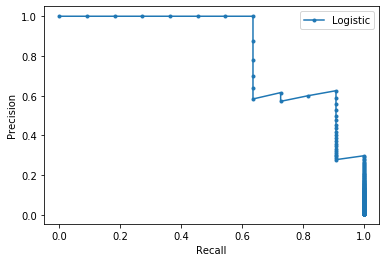

Word : 301-03-04 (I-n-s-t-r-u-c-t-i-o-n-s-s_pt)
Logistic: AP=0.773


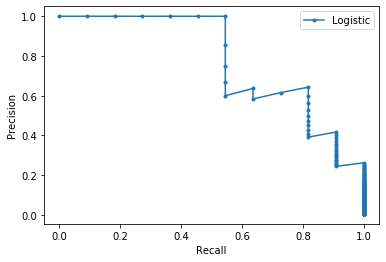

Word : 302-01-05 (I-n-s-t-r-u-c-t-i-o-n-s-s_pt)
Logistic: AP=0.757


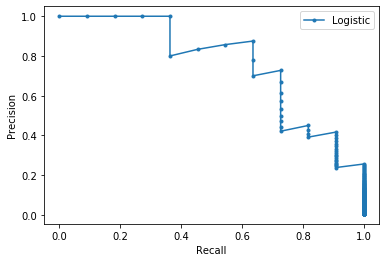

Word : 304-01-05 (I-n-s-t-r-u-c-t-i-o-n-s-s_pt)
Logistic: AP=0.810


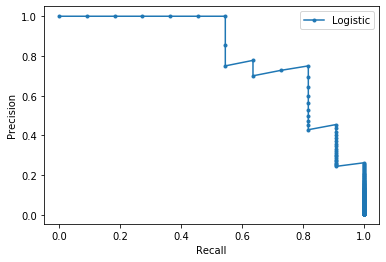

Word : 304-11-03 (J-o-h-n)
Logistic: AP=1.000


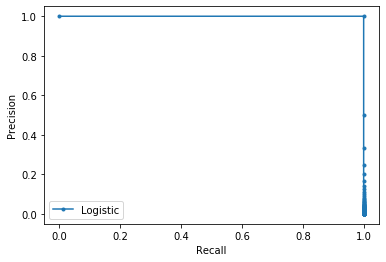

Word : 304-32-02 (O-f-f-i-c-e-r-s)
Logistic: AP=0.519


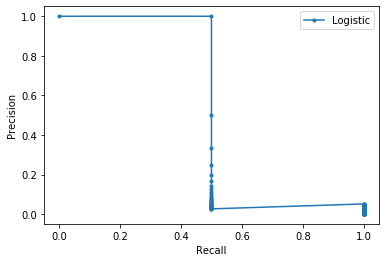

In [74]:
for word in final_results.keys():
    lr_precision, lr_recall = precision_recall_data[word][0], precision_recall_data[word][1]
    lr_auc = auc(lr_recall, lr_precision)
    if lr_auc > 0.5 :
        print(f'Word : {word} ({transcription[word]})')
        print('Logistic: AP=%.3f' % lr_auc)

        plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
        # axis labels
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        # show the legend
        plt.legend()
        # show the plot
        plt.show()

#### Plot the final precision-recall curve (average of all the words)

Logistic: AP=0.059


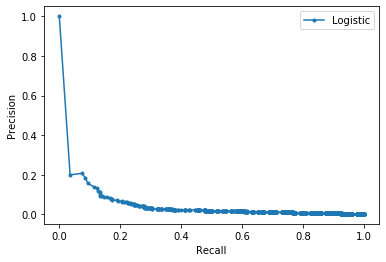

In [73]:
# initialize mean precision and mean recall
lr_mean_precision = []
lr_mean_recall = []
for i in range(0, len(final_results[word])):
    lr_mean_precision.append(0)
    lr_mean_recall.append(0)
# compute the mean precision and recall   
for word in final_results.keys():
    lr_precision, lr_recall = precision_recall_data[word][0], precision_recall_data[word][1]
    lr_mean_precision = [x + y for x, y in zip(lr_mean_precision, lr_precision)]
    lr_mean_recall = [x + y for x, y in zip(lr_mean_recall, lr_recall)]
    
lr_mean_precision= [idx/len(final_results) for idx in lr_mean_precision]
lr_mean_recall= [idx/len(final_results) for idx in lr_mean_recall]

# plot the results
lr_mean_auc = auc(lr_mean_recall, lr_mean_precision)
print('Logistic: AP=%.3f' % lr_mean_auc)
plt.plot(lr_mean_recall, lr_mean_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()